In [1]:
import numpy as np
import os
# from scipy.misc import imread, imresize
import cv2
from cv2 import imread, resize
import datetime
import os
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
# from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [4]:
tf.config.list_physical_devices('GPU')

2021-12-26 14:49:57.090734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 14:49:57.098053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 14:49:57.098355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
# train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
# val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())
train_doc = np.random.permutation(open('../data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('../data/Project_data/val.csv').readlines())
batch_size = 4 #experiment with the batch size

In [6]:
len(train_doc), len(val_doc)

(663, 100)

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = '../data/Project_data/train'
val_path = '../data/Project_data/val'

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
def resize_image(image, y, z, channels):
    if (y, z) == (120, 120):
        if image.shape[1] == 360:
            image = resize(image, (y, z), interpolation=cv2.INTER_LINEAR)
        elif image.shape[1] == 160:
            image = image[:, 20:140]
        return image
    elif (y, z) == (160, 160):
        if image.shape[1] == 360:
            image = resize(image, (y, z), interpolation=cv2.INTER_LINEAR)
        elif image.shape[1] == 160:
            image = np.concatenate([np.zeros((20, 160, channels)), image[:, :], np.zeros((20, 160, channels))], axis=0)
        return image

In [9]:
# def generator(source_path, folder_list, batch_size):
#     print( 'Source path = ', source_path, '; batch size =', batch_size)
#     #create a list of image numbers you want to use for a particular video
#     img_idx = list(range(30))[::3]
#     while True:
#         t = np.random.permutation(folder_list)
#         # calculate the number of batches
#         num_batches = len(folder_list) // batch_size
        
#         x = len(img_idx)
#         y, z = (120, 120)
#         for batch in range(num_batches): # we iterate over the number of batches
#             # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
#             batch_data = np.zeros((batch_size,x,y,z,3)) 
#             # batch_labels is the one hot representation of the output
#             batch_labels = np.zeros((batch_size,5)) 
#             for folder in range(batch_size): # iterate over the batch_size
#                 imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
#                 for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
#                     image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
#                     #videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos)
#                     #crop the images and resize them. Note that the images are of 2 different shape 
#                     #and the conv3D will throw error if the inputs in a batch have different shapes
#                     image = resize_image(image)
#                     assert image.shape == (y, z, 3), print(f'{image.shape} || {(y, z, 3)}')
                    
#                     #normalise and feed in the image
#                     image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
#                     batch_data[folder,idx,:,:,0] = image[:,:,0]
#                     batch_data[folder,idx,:,:,1] = image[:,:,1]
#                     batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
#                 batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#             yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
#         # write the code for the remaining data points which are left after full batches
        

In [10]:
# def generator(source_path, folder_list, batch_size):
#     print( 'Source path = ', source_path, '; batch size =', batch_size)
    
#     #create a list of image numbers you want to use for a particular video
#     img_idx = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 27, 28, 29]
#     channels = 3
    
#     while True:
        
#         t = np.random.permutation(folder_list)
        
#         # calculate the number of batches
#         if len(folder_list) % batch_size == 0:
#             num_batches = len(folder_list) // batch_size
#         else:
#             num_batches = (len(folder_list) // batch_size) + 1
            
#         x = len(img_idx)
#         y, z = (120, 120) #image height, image width
        
#         for batch in range(num_batches): # we iterate over the number of batches
#             num_covered_images = batch*batch_size # images already batched
#             num_images_left = len(folder_list) - num_covered_images # images left to be batched
#             # if images left are less than batch size (partial last batch)
#             # then update batch size
#             batch_size = num_images_left if (num_images_left < batch_size) else batch_size
#             # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
#             batch_data = np.zeros((batch_size,x,y,z,channels)) 
#             # batch_labels is the one hot representation of the output
#             batch_labels = np.zeros((batch_size,5)) 
#             for folder in range(batch_size): # iterate over the batch_size
#                 imgs = os.listdir(source_path+'/'+ t[num_covered_images + folder].split(';')[0]) # read all the images in the folder
#                 for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
#                     image = imread(source_path+'/'+ t[num_covered_images + folder].strip().split(';')[0]+'/'+imgs[item])#.astype(np.float32)
                    
#                     #videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos)
#                     #crop the images and resize them. Note that the images are of 2 different shape 
#                     #and the conv3D will throw error if the inputs in a batch have different shapes
#                     image = resize_image(image, y, z)
#                     assert image.shape == (y, z, 3), print(f'{image.shape} || {(y, z, 3)}')
                    
#                     #normalise and feed in the image
#                     image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
#                     batch_data[folder,idx,:,:,0] = image[:,:,0]
#                     batch_data[folder,idx,:,:,1] = image[:,:,1]
#                     batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
#                 batch_labels[folder, int(t[num_covered_images + folder].strip().split(';')[2])] = 1
#             yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        

In [11]:
def generator(source_path, folder_list, batch_size, grayscale=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 27, 28, 29]
    channels = 1 if grayscale else 3
    
    while True:
        
        t = np.random.permutation(folder_list)
        
        # calculate the number of batches
        if len(folder_list) % batch_size == 0:
            num_batches = len(folder_list) // batch_size
        else:
            num_batches = (len(folder_list) // batch_size) + 1
            
        x = len(img_idx)
        # y, z = (120, 120) #image height, image width
        y, z = (160, 160) #image height, image width
        
        for batch in range(num_batches): # we iterate over the number of batches
            num_covered_images = batch*batch_size # images already batched
            num_images_left = len(folder_list) - num_covered_images # images left to be batched
            # if images left are less than batch size (partial last batch)
            # then update batch size
            batch_size = num_images_left if (num_images_left < batch_size) else batch_size
            # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros((batch_size,x,y,z,channels)) 
            # batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5)) 
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[num_covered_images + folder].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[num_covered_images + folder].strip().split(';')[0]+'/'+imgs[item])#.astype(np.float32)
                    
                    #videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_image(image, y, z, channels)
                    assert image.shape == (y, z, 3), print(f'{image.shape} || {(y, z, 3)}') # keep channels 3, not yet converted to grayscale
                    
                    #normalise and feed in the image
                    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                    
                    if grayscale:
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        batch_data[folder,idx,:,:,0] = image[:,:]
                    else:
                        batch_data[folder,idx,:,:,0] = image[:,:,0]
                        batch_data[folder,idx,:,:,1] = image[:,:,1]
                        batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[num_covered_images + folder].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        

In [12]:
one_batch = next(generator(train_path, train_doc, batch_size, grayscale=False))
one_batch[0].shape, one_batch[1].shape

Source path =  ../data/Project_data/train ; batch size = 4


((4, 18, 160, 160, 3), (4, 5))

In [13]:
# num_covered_images = 90
# folder = 3
# item = 10
# y, z = (120, 120)
# t = np.random.permutation(train_doc)
# imgs = os.listdir(train_path+'/'+ t[num_covered_images + folder].split(';')[0])
# image = imread(train_path+'/'+ t[num_covered_images + folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

In [14]:
# image.shape

In [15]:
# if image.shape[1] == 360:
#     image = resize(image, (y, z), interpolation=cv2.INTER_LINEAR)
# elif image.shape[1] == 160:
#     image = image[:, 20:140]

In [16]:
# image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

In [17]:
# image

In [18]:
# plt.imshow(image)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [19]:
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [20]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers, layers
from tensorflow.keras.layers import Conv2D, Conv3D, Input, Flatten, Dense, Dropout, GRU, LSTM, TimeDistributed
from tensorflow.keras.layers import MaxPooling2D, MaxPooling3D, BatchNormalization, GlobalAveragePooling2D, GlobalAveragePooling3D

In [21]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [22]:
#write your model here
def create_model_cnn3d(width=120, height=120, frames=30, channels=3):
    """Build a 3D convolutional neural network model."""
    
    inputs = keras.Input((width, height, frames, channels))

    x = layers.Conv3D(filters=64, kernel_size=3, strides=1, padding='same', activation="relu")(inputs)
    x = layers.MaxPooling3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=128, kernel_size=3, strides=1, padding='same', activation="relu")(x)
    x = layers.MaxPooling3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, strides=1, padding='same', activation="relu")(x)
    x = layers.MaxPooling3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units=1024, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    
    outputs = layers.Dense(units=5, activation="softmax")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model

In [23]:
# #write your model here
# def create_model_cnn3d(width=120, height=120, depth=30, channels=3):
#     """Build a 3D convolutional neural network model."""

#     inputs = keras.Input((width, height, depth, channels))

#     x = layers.Conv3D(filters=64, kernel_size=3, strides=1, padding='same', activation="relu")(inputs)
#     x = layers.Conv3D(filters=64, kernel_size=3, strides=1, padding='same', activation="relu")(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization()(x)

#     # x = layers.Conv3D(filters=64, kernel_size=3, strides=1, padding='same', activation="relu")(x)
#     # x = layers.MaxPool3D(pool_size=2)(x)
#     # x = layers.BatchNormalization()(x)

#     x = layers.Conv3D(filters=128, kernel_size=3, strides=1, padding='same', activation="relu")(x)
#     x = layers.Conv3D(filters=128, kernel_size=3, strides=1, padding='same', activation="relu")(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization()(x)

#     x = layers.Conv3D(filters=256, kernel_size=3, strides=1, padding='same', activation="relu")(x)
#     x = layers.Conv3D(filters=256, kernel_size=3, strides=1, padding='same', activation="relu")(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization()(x)

#     x = layers.GlobalAveragePooling3D()(x)
#     x = layers.Dense(units=1024, activation="relu")(x)
#     x = layers.Dropout(0.2)(x)
#     x = layers.Dense(units=256, activation="relu")(x)
#     x = layers.Dropout(0.2)(x)
    
#     outputs = layers.Dense(units=5, activation="softmax")(x)

#     # Define the model.
#     model = keras.Model(inputs, outputs, name="3dcnn")
#     return model

In [24]:
#write your model here
def create_model_tdcnn(width=120, height=120, frames=30, channels=3):
    """Build a 3D convolutional neural network model."""

    inputs = Input((frames, width, height, channels))

    x = TimeDistributed(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation="relu"))(inputs)
    x = TimeDistributed(MaxPooling2D(pool_size=2))(x)
    x = TimeDistributed(BatchNormalization())(x)

    x = TimeDistributed(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation="relu"))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=2))(x)
    x = TimeDistributed(BatchNormalization())(x)

    x = TimeDistributed(Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation="relu"))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=2))(x)
    x = TimeDistributed(BatchNormalization())(x)

    # x = GlobalAveragePooling2D()(x)
    x = TimeDistributed(Flatten())(x)
    
    # x = GRU(units=256, return_sequences=True)(x)
    x = GRU(units=256)(x)
    
    x = Dense(units=1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(units=256, activation="relu")(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(units=5, activation="softmax")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="tdcnn")
    return model

In [25]:
#write your model here
def create_model_tdcnn_pretrained(width=120, height=120, frames=30, channels=3):
    """Build a 3D convolutional neural network model."""
    
    # create the base pre-trained model
    base_model = MobileNetV2(weights='imagenet', include_top=False)
    
    inputs = Input((frames, width, height, channels))

    x = TimeDistributed(base_model)(inputs)

    x = TimeDistributed(GlobalAveragePooling2D())(x)
    x = TimeDistributed(Flatten())(x)
    
    # x = GRU(units=256, return_sequences=True)(x)
    x = GRU(units=256)(x)
    
    x = Dense(units=1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(units=256, activation="relu")(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(units=5, activation="softmax")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="tdcnn")
    return model

In [26]:
# Build model.
grayscale = False
frames = one_batch[0].shape[1]
channels = 1 if grayscale else 3

# model = create_model_cnn3d(width=120, height=120, frames=frames, channels=channels)
# model = create_model_tdcnn(width=120, height=120, frames=frames, channels=channels)
model = create_model_tdcnn_pretrained(width=160, height=160, frames=frames, channels=channels)
model.summary()

2021-12-26 14:49:58.644052: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-26 14:49:58.644660: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 14:49:58.644952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 14:49:58.645166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Model: "tdcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 18, 160, 160, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 18, 5, 5, 1280)   2257984   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 1280)         0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 1280)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 256)               118118

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [27]:
learning_rate = 5e-5
optimiser = keras.optimizers.Adam(learning_rate=learning_rate) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [28]:
train_generator = generator(train_path, train_doc, batch_size, grayscale=grayscale)
val_generator = generator(val_path, val_doc, batch_size, grayscale=grayscale)

In [29]:
model_name = '../models/model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)
# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
# callbacks_list = [checkpoint, LR, early_stop]
callbacks_list = [checkpoint, early_stop]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [30]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [31]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../data/Project_data/train ; batch size = 4
Epoch 1/50


2021-12-26 14:50:06.246245: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204
2021-12-26 14:50:07.490047: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 844.05MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-26 14:50:07.510562: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 968.19MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-26 14:50:07.792891: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more me

165/166 [============================>.] - ETA: 0s - loss: 1.6303 - categorical_accuracy: 0.2379

2021-12-26 14:51:36.353664: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 674.13MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-26 14:51:36.793742: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 955.53MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


166/166 [==============================] - ETA: 0s - loss: 1.6304 - categorical_accuracy: 0.2368Source path =  ../data/Project_data/val ; batch size = 4

Epoch 00001: saving model to ../models/model_init_2021-12-2614_49_57.271093/model-00001-1.63040-0.23680-1.49032-0.43000.h5
166/166 [==============================] - 103s 579ms/step - loss: 1.6304 - categorical_accuracy: 0.2368 - val_loss: 1.4903 - val_categorical_accuracy: 0.4300
Epoch 2/50
166/166 [==============================] - ETA: 0s - loss: 1.4404 - categorical_accuracy: 0.3855
Epoch 00002: saving model to ../models/model_init_2021-12-2614_49_57.271093/model-00002-1.44041-0.38554-1.21093-0.60000.h5
166/166 [==============================] - 72s 436ms/step - loss: 1.4404 - categorical_accuracy: 0.3855 - val_loss: 1.2109 - val_categorical_accuracy: 0.6000
Epoch 3/50
166/166 [==============================] - ETA: 0s - loss: 1.2125 - categorical_accuracy: 0.5100
Epoch 00003: saving model to ../models/model_init_2021-12-2614_49_5

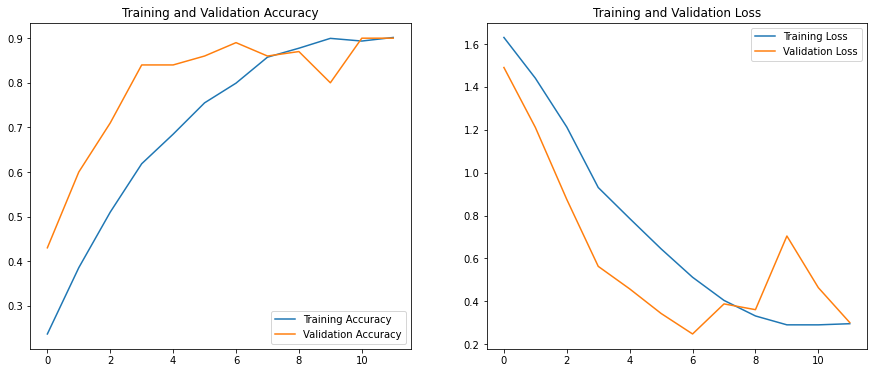

In [32]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()